# Notebook to showcase the EnergyDemandPredictor

## Baseline model

### Boosted tree

The second baseline model we look at is a boosted tree. Here, we use XGBoost for implementation.

In [1]:
from edf.inout import read_dataframe_from_sql, resolve_path
from edf.metrics import compute_metrics
import matplotlib.pyplot as plt
from edf.baselines import XGBoostBaseline
import numpy as np

In [2]:
db_path = resolve_path('..', 'data', 'raw', 'time_series.sqlite')
table_name = 'time_series_15min_singleindex'
column_names = ['utc_timestamp', 'NL_load_actual_entsoe_transparency']
timestamp_col = 'utc_timestamp'
timestamp_format = '%Y-%m-%dT%H:%M:%SZ'

df = read_dataframe_from_sql(
    db_path, table_name, column_names, timestamp_col, timestamp_format)

horizons = [4, 48, 96,] # 1h, 12h and 24h
lags = [1, 4, 47, 48, 49, 95, 96, 97, 96*7-1, 96*7, 96*7+1] # 1h, 24h and 1 week
rolling_windows = [12, 24, 48, 96*7] # 3h, 6h and 12h, 1 week
model = XGBoostBaseline(lags=lags, horizons=horizons, rolling_windows=rolling_windows)


param_grid = {
    'max_depth': [6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_lambda': [1.0, 5.0],
    'min_child_weight': [1.0, 5.0],
    'n_estimators': [4000],
    'early_stopping_rounds': [200]
}

train_frac=0.8

model.train(
    df,
    train_frac=train_frac,
    feature_column='NL_load_actual_entsoe_transparency',
    param_grid=param_grid,
)


Horizon:   0%|          | 0/3 [00:00<?, ?it/s]

h=4:   0%|          | 0/72 [00:00<?, ?it/s]

Best params for h=4: {'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'reg_lambda': 1.0, 'min_child_weight': 1.0, 'n_estimators': 4000, 'early_stopping_rounds': 200} | Test metrics: ({'MAE': 219.87564086914062, 'MSE': 109944.21875, 'RMSE': 331.578369140625, 'MAPE': 1.8112881183624268}, {'MAE': 219.87564086914062, 'MSE': 109944.21875, 'RMSE': 331.578369140625, 'MAPE': 1.8112881183624268})


h=48:   0%|          | 0/72 [00:00<?, ?it/s]

Best params for h=48: {'max_depth': 8, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 5.0, 'min_child_weight': 1.0, 'n_estimators': 4000, 'early_stopping_rounds': 200} | Test metrics: ({'MAE': 518.764892578125, 'MSE': 684423.9375, 'RMSE': 827.2991943359375, 'MAPE': 4.472409248352051}, {'MAE': 518.764892578125, 'MSE': 684423.9375, 'RMSE': 827.2991943359375, 'MAPE': 4.472409248352051})


h=96:   0%|          | 0/72 [00:00<?, ?it/s]

Best params for h=96: {'max_depth': 8, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 1.0, 'min_child_weight': 1.0, 'n_estimators': 4000, 'early_stopping_rounds': 200} | Test metrics: ({'MAE': 458.93505859375, 'MSE': 476780.875, 'RMSE': 690.4932250976562, 'MAPE': 3.8708012104034424}, {'MAE': 458.93505859375, 'MSE': 476780.875, 'RMSE': 690.4932250976562, 'MAPE': 3.8708012104034424})


{'MAE': 219.8756342493801, 'MSE': 109944.22703625707, 'RMSE': 331.5783874685699, 'MAPE': 1.8112881964899912}


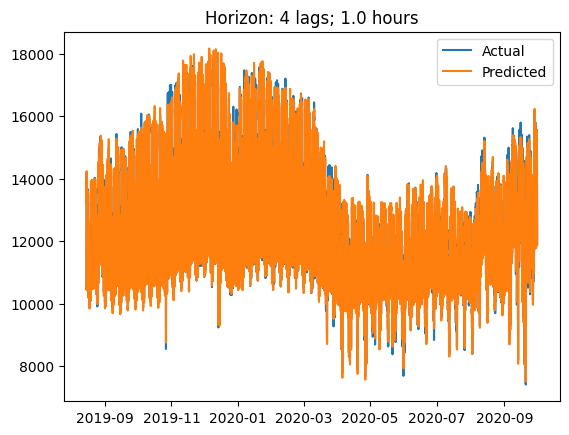

{'MAE': 518.7649350206743, 'MSE': 684423.9327402018, 'RMSE': 827.2991797047799, 'MAPE': 4.472409192423546}


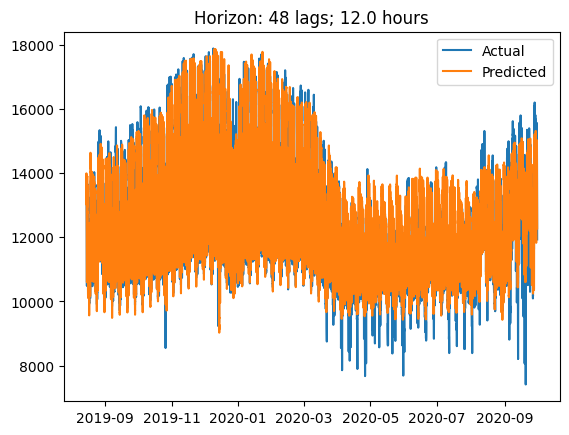

{'MAE': 458.93505813718184, 'MSE': 476780.8691484624, 'RMSE': 690.4932071703981, 'MAPE': 3.87080115276789}


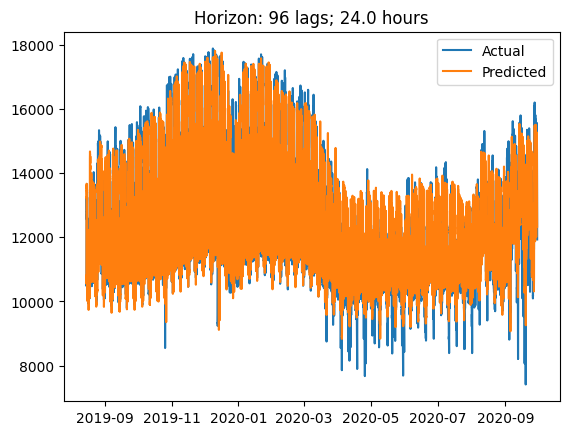

In [10]:

test_idx_start = int(len(df) * train_frac)
for horizon in horizons:
    df_test = df.iloc[test_idx_start:]
    df_test = model.predict(df_test, horizon=horizon)
    metrics, _ = compute_metrics(
        df_test[f'actual_horizon_{horizon}'],
        df_test[f'predicted_horizon_{horizon}']
    )
    print(metrics)
    plt.plot(df_test[f'actual_horizon_{horizon}'], label='Actual')
    plt.plot(df_test[f'predicted_horizon_{horizon}'], label='Predicted')
    plt.legend()
    plt.title(f'Horizon: {horizon} lags; {horizon/4} hours')
    plt.show()


## LSTM V0

### Training

We first have to change the base directory to be at *ElectricitydemandForecasterNL*

In [10]:
import os 

current_dir = os.getcwd()

target_folder = 'ElectricityDemandForecasterNL'
current_dir = os.getcwd()

parts = current_dir.split(os.sep)

if target_folder in parts:
    target_index = parts.index(target_folder) + 1
    new_path = os.sep.join(parts[:target_index])
    os.chdir(new_path)
    print("Changed working directory to:", os.getcwd())
else:
    print(f"'{target_folder}' not found in path {current_dir}")

Changed working directory to: /Users/moritz/Documents/AI/Projects/ElectricityDemandForecasterNL


To train a model we can the following cell: 

In [ ]:
from edf.train_cli import main
import os

main(
    db_path= "data/raw/time_series.sqlite",
    table_name=  "time_series_15min_singleindex",
    config_path= "electricitydemandforecaster/configs/base_lstm_minimal.yaml",
    runs_root=  "electricitydemandforecaster/runs", 
    run_cv = False, # If we run cross validation or not 
    fraction = 1 # Fraction of the data to use for training
)



### Evaluation

The resulting model run of the model is saved under: *electricitydemandforecaster/runs/2025-08-23_13-32-41*.

Now we can evaluate the test split of the run:

In [ ]:
from edf.evaluate import run_test
from pathlib import Path

metrics = run_test(Path('electricitydemandforecaster/runs/2025-08-23_13-32-41'), plot_horizons=[96], save_plots=True)

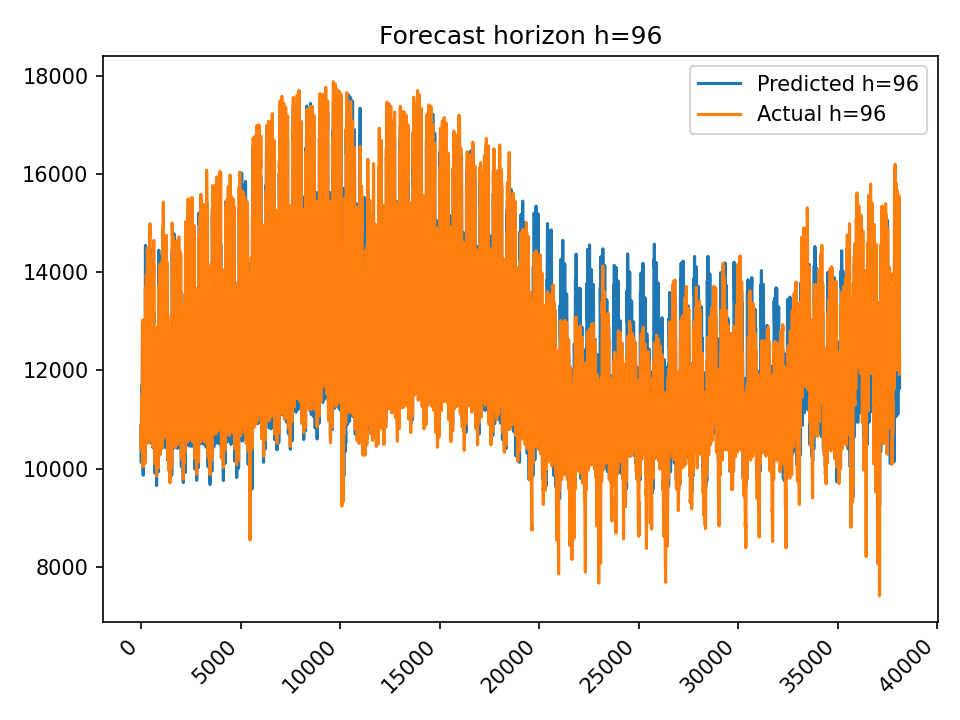

In [25]:
from IPython.display import Image, display

display(Image(Path('electricitydemandforecaster/runs/2025-08-23_13-32-41/eval_plots/eval_plot_h96.png'),width= 600), )

In [ ]:
print('The mean error of the metrics is:')
metrics['overall']

The mean error of the metrics is:


{'MAE': 526.3349609375,
 'MSE': 608408.9375,
 'RMSE': 771.7750854492188,
 'MAPE': 4.4223551750183105}

We can further look at the MAE error per horizon: 

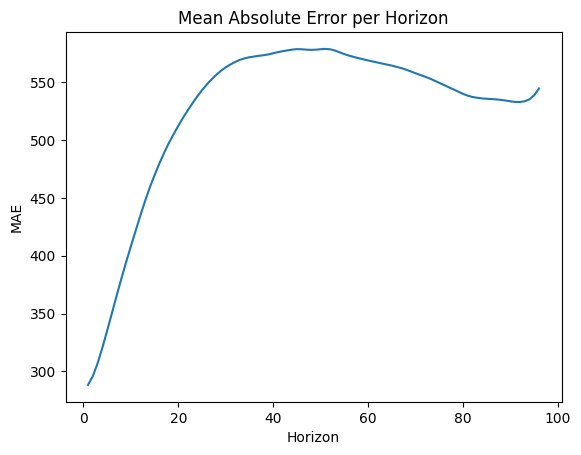

544.7467651367188

In [28]:
import matplotlib.pyplot as plt

plt.plot(range(1, 97), metrics['per_horizon']['MAE'])
plt.xlabel('Horizon')
plt.ylabel('MAE')
plt.title('Mean Absolute Error per Horizon')
plt.show()

metrics['per_horizon']['MAE'][95]

### Prediction

To predict using the LSTM model of a specific run we can run the following cell:

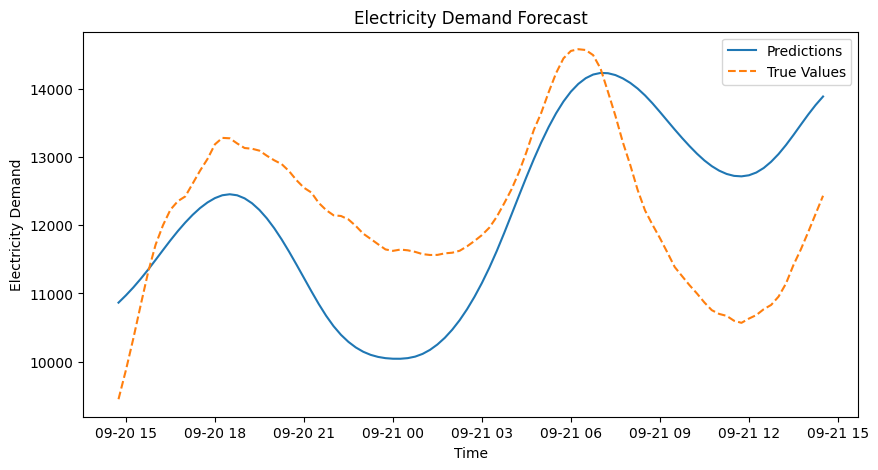

In [ ]:
from datetime import datetime
from edf.evaluate import predict_at
from pathlib import Path
import matplotlib.pyplot as plt


timestamp = datetime(2020, 9, 20, 14, 37, 19)
predict_path = Path('electricitydemandforecaster/runs/2025-08-23_13-32-41')

predictions, y_true, timesteps = predict_at(predict_path, timestamp=timestamp)

fig = plt.figure(figsize=(10, 5))
plt.plot(timesteps, predictions, label='Predictions')
plt.plot(timesteps, y_true, label='True Values', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Electricity Demand')
plt.title('Electricity Demand Forecast')
plt.legend()
plt.show()

### Conclusion baseline LSTM

The baseline LSTM does not perform as good as the boosted tree (MSE of tree 496 vs. 544 for LSTM). To improve the LSTM we have multiple possibilities:

1. Combine model with CNN to extract more features from the data.
2. Add additional weather features like temperature or irradiance.
3. Increase the lookback time. 

## LSTM with weather 

To improve the performance of the LSTM, we can add weather features to the model. 

In [1]:
import optuna

path = '../electricitydemandforecaster/runs/2025-08-31_18-57-06'
path = f'sqlite:///{path}/optuna_optimization.db'
print(path)
study = optuna.load_study(
    study_name='hyperparameter_optimization',
    storage=path
)

sqlite:///../electricitydemandforecaster/runs/2025-08-31_18-57-06/optuna_optimization.db


In [2]:
from optuna.visualization import plot_optimization_history

fig = plot_optimization_history(study)
fig.show()